In [1]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
F mild changes to base classes:

- `graphs(..., fix_aspect=False)` optional arg to stop scaling of the visuals; and addition of low-quality station id labels
- `__repr__` for station is slightly different, was getting confused if I was dealing with 0 or Station 0

Other key points:

- Test cases in json file, I'll add to this but so far the main ones are `hexagon`, `loop_feasibility` and the `_cluster` family. See how-to import in new notebook


# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [2]:
# Load test cases
# Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)

In [3]:
# Choose problem to use in code below
test_choice = "hexagon"
N_STATIONS = tests[test_choice]["n_stations"]
locations = tests[test_choice]["locations"]
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

dist = gen_distance_matrix(city)
S = list(range(N_STATIONS))
subs = subsets(S)

In [4]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

x = m.addVars(N_STATIONS, N_STATIONS, vtype=GRB.INTEGER, name="x")

m.setObjective(gp.quicksum(dist[s1, s2]*x[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

# leave each station only once
m.addConstrs(gp.quicksum(x[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
# enter each station only once
m.addConstrs(gp.quicksum(x[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
# Subtour elimination constraints
for sub in subs:
    m.addConstr(gp.quicksum(x[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-03
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 70 rows, 49 columns and 336 nonzeros
Model fingerprint: 0xd0966d93
Variable types: 0 continuous, 49 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 11.7459421
Presolve removed 0 rows and 7 columns
Presolve time: 0.00s
Presolved: 70 rows, 42 columns, 336 nonzeros
Variable types: 0 continuous, 42 integer (42 binary)

Root relaxation: objective 7.294827e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     

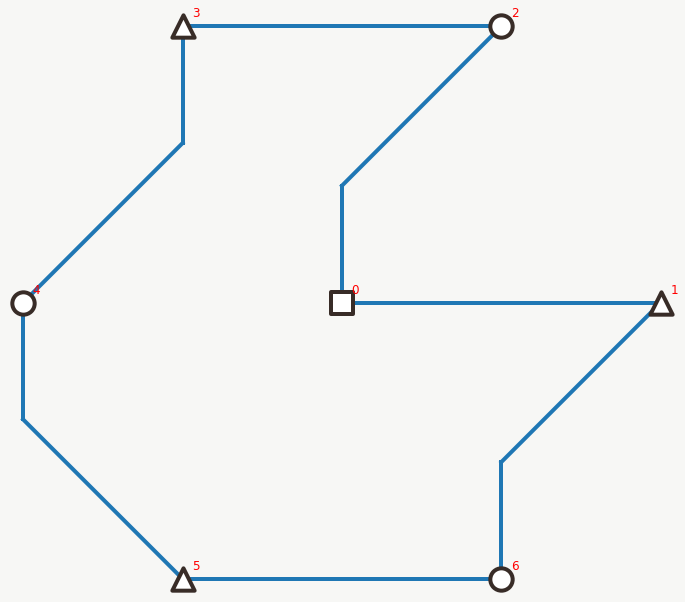

In [5]:
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True)

## Stage 2 - MIP Approach

In [6]:
def demand_by_centrality(stations, C=3):
    """Simple proxy demand for testing the framework
    # d = Cexp(-norm_2(rescaled(s - map_midpoint)))
    # Rescaled(s) = s' is s.t. norm_1(s') <= 1
    # And map_midpoint = midpoint/center of the minimal bounding box for the stations
    #
    # ASSUMES:
    # That more central stations (by how MM generates its worlds) get/need more traffic
    """
    import math
    lb = min([s.x for s in stations])
    rb = max([s.x for s in stations])
    db = min([s.y for s in stations])
    ub = max([s.y for s in stations])

    cx = (lb+rb)/2
    cy = (db+ub)/2
    d = np.zeros([n])
    for i,s in enumerate(stations):
        d[i] = C*math.exp(-math.sqrt(((s.x-cx)/(rb-lb))**2 + ((s.y-cy)/(ub-lb))**2))
    return d

In [25]:
# A few modifications, but otherwise the same hyperparameters
n = N_STATIONS  # no. customers
M = 3
D = range(M) # set of vehicles
V = S  # customers
DUMMY = n  # dummy depot's index
V0 = S + [DUMMY]  # customers + depot

Q = n  # capacities of vehicles (assumed homogenous)
K = 1 # 3
L = 100 # N_STATIONS - (M-1)*K
mk = 1 # Num trains from kth depot

# Slightly larger cost matrix, just with a row/col of zeros for the dummy depot
cost = np.zeros([n+1,n+1])
cost[:n,:n] = dist 

# Demands. Unit demands is TSP-like if capacity Q = |S|
# d = np.ones([n])

# OR assign demand based on centrality. Normalise demand to ensure feasibility
d = demand_by_centrality(stations, C=2)
d = d * Q * M / d.sum()

# Special-case: A `hexagon` demand assignment to showcase overlapping
# d = [0.8, 8, 0.8, 8, 0.8, 0.8, 0.8]

## SDVRP - Based Implementation

*Done, but needs cleaning, and may not be most powerful MIP model possible*

**Origin**: Archetti et al.'s Tabu search paper <a href="https://www.jstor.org/stable/25769283">here</a> though it is expanded on in **The Split Delivery Vehicle Routing Problem: A Survey** (Archetti et al.) <a href=" https://www-or.amp.i.kyoto-u.ac.jp/ramp2006/paper/2-1.pdf">here</a>

### Modifications made to the SDVRP model above:

0. I have been setting 'demands' to be inversely proportional to the 'centre' of the city network; this is to introduce higher-demand cities in an attempt to promote crossings.
1. Added a single 'dummy depot' from which all vehicles must leave and enter. This is to detach from 'specified/fixed depot' concept.
2. Added extra constraints to discourage self-joins (could probably merge into another constraint)
3. Added extra constraints to enforce that all vehicles must leave, and enter, dummy depot exactly once
4. Switched from DFJ SEC's to MTZ SEC's; I feel it is easier to work with when it comes to allowing loops within a route, and furthermore avoids exponentially many constraints
5. Modified MTZ SEC to 'allow' a subtour-forming join IF that node would connect directly to the dummy depot

> (Refresher: MTZ SEC's) $u_i − u_j+ px_{ij} \leq p − 1\quad\forall i,j \in V$ (here $p$ = `N_STATIONS`)

> (What I used) $u_i^{[k]} − u_j^{[k]}+ px_{ij}^{[k]} \leq p − 1 + px_{jD}^{[k]}\quad\forall i,j \in V,\ k\in D$

- Idea: if (i -> j), if j is not the last trainstop prior to a depot, then it's just ordinary MTZ but per-route
- If however (i -> j) and (j -> depot) then (because we'll have u[j,k] = 0 < u[i,k]) we add in p again 

6. Capacities of vehicles/trains are homogenous, but easily modifiable

In [26]:
m = gp.Model()
MIN_EDGES = 3  # relevant to an extra constraint that avoids short-lived train stops; Ants approach would do better here

x = m.addVars(N_STATIONS+1, N_STATIONS+1, M, vtype=GRB.INTEGER, name="x") # node i --> node j on path of vehicle k
y = m.addVars(N_STATIONS, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
u = m.addVars(N_STATIONS, M, lb=0.0, name="u")  # MTZ potentials

m.setObjective(gp.quicksum(cost[i,j]*x[i,j,k] for i in V0 for j in V0 for k in D), GRB.MINIMIZE)

# EDGE CONSISTENCY CONSTRAINTS

# 2: at least one edge enters every j (including the depot)
m.addConstrs(gp.quicksum(x[i,j,k] for i in V0 for k in D) >= 1 for j in V0)
# 3: in == out for every node + depot, per-route basis (and hence in general)
m.addConstrs((gp.quicksum(x[i,j,k] for i in V0) - gp.quicksum(x[j,i,k] for i in V0) == 0 for j in V0 for k in D))

# SUBTOUR CONSTRAINTS 
# 4_modified: SEC using MTZ
m.addConstrs((u[i,k] - u[j,k] + N_STATIONS*x[i,j,k] <= N_STATIONS-1 + \
                  N_STATIONS*x[j,DUMMY,k] for i in V for j in V if i != j for k in D))

# DEMAND CONSTRANTS

# 5: ith demand can only be sated by route k if there's an outbound edge from i on that path
m.addConstrs(y[i,k] <= d[i]*gp.quicksum(x[i,j,k] for j in V0) for i in V for k in D)

# 6: total sated demand @ i must meet demand
m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in V)

# 7: (MODIFIED FOR HOMOGENOUS CAPACITY) total sated demand by k cannot exceed capacity of vehicle
m.addConstrs((gp.quicksum(y[i,k] for i in V) <= Q for k in D))

# 8,9: Domain constraints (already handled)

# EXTRA constraints

# X1. No self-joins
m.addConstrs(x[i,i,k] <= 0 for i in V0 for k in D)
# X2. For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
m.addConstrs(gp.quicksum(x[i,DUMMY,k] for i in V) == mk for k in D)
m.addConstrs(gp.quicksum(x[DUMMY,i,k] for i in V) == mk for k in D)
# X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
# X4. Routes must have more than 2 edges
m.addConstrs((gp.quicksum(x[i,j,k] for i in V0 for j in V0) >= MIN_EDGES for k in D))

# Experimental constraints

# E1. If d() satisfies triangle ineq, then for a pair of routes, can only share one customer (see the Survey paper)
# == NO EDGE SHARING
# m.addConstrs((gp.quicksum(x[i,j,k] for k in D) <= 1 for i in V for j in V))
# E2. (added for negative costs to stop lollygagging) 
# total number of edges should not exceed N_STATIONS + 2*M (to allow loops)
# m.addConstr(gp.quicksum(x[i,j,k] for i in V0 for j in V0 for k in D) <= N_STATIONS + 2*M)

# Special case: Used for testing feasibility of a loop in "loop_feasibility" (3 here is the depot)
#m.addConstr(x[3,2,0] == 1)
#m.addConstr(x[2,1,0] == 1)
#m.addConstr(x[1,0,0] == 1)
#m.addConstr(x[0,2,0] == 1)
#m.addConstr(x[2,3,0] == 1)

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 369 rows, 234 columns and 1794 nonzeros
Model fingerprint: 0x04eba70f
Variable types: 42 continuous, 192 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 16.3749049
Presolve removed 112 rows and 24 columns
Presolve time: 0.00s
Presolved: 257 rows, 210 columns, 1449 nonzeros
Variable types: 42 continuous, 168 integer (168 binary)

Root relaxation: objective 4.000000e+00, 103 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.00000    0    8   16.37490    4.00000  75.6%     -    0s
H    0     0                      

In [27]:
for var in m.getVars():
    if abs(var.x) > 0 or var.varName[0] in "y":
        print(var.varName, var.x)

x[0,1,0] 1.0
x[0,3,2] 1.0
x[1,7,0] 1.0
x[2,7,2] 1.0
x[3,2,2] 1.0
x[4,0,2] 1.0
x[4,7,1] 1.0
x[5,4,1] 1.0
x[6,5,1] 1.0
x[7,0,0] 1.0
x[7,4,2] 1.0
x[7,6,1] 1.0
y[0,0] 4.215225343030216
y[0,1] 0.0
y[0,2] 0.3760918680225336
y[1,0] 2.784774656969793
y[1,1] 0.0
y[1,2] 0.0
y[2,0] 0.0
y[2,1] 0.0
y[2,2] 2.709783368751917
y[3,0] 0.0
y[3,1] 0.0
y[3,2] 2.709783368751917
y[4,0] 0.0
y[4,1] 1.5804332624961663
y[4,2] 1.2043413944736265
y[5,0] 0.0
y[5,1] 2.709783368751917
y[5,2] 0.0
y[6,0] 0.0
y[6,1] 2.709783368751917
y[6,2] 0.0
u[0,2] 1.0000000000000004
u[3,2] 2.0
u[5,1] 1.0


In [28]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<0>, <1>, 0],
 [<0>, <3>, 2],
 [<3>, <2>, 2],
 [<4>, <0>, 2],
 [<5>, <4>, 1],
 [<6>, <5>, 1]]

defaultdict(list,
            {0: [[<0>, <1>]],
             2: [[<0>, <3>], [<3>, <2>], [<4>, <0>]],
             1: [[<5>, <4>], [<6>, <5>]]})

In [29]:
# Flawed - cannot handle the below (hexagon-generated with negative costs)
"""
defaultdict(list,
            {0: [[<0>, <3>],
              [<1>, <4>],
              [<2>, <5>],
              [<3>, <6>],
              [<4>, <2>],
              [<5>, <1>],
              [<6>, <4>]]})"""

def modified_pairs2rails(pairs, debug=False):
    starts = [pair[0] for pair in pairs]
    ends   = [pair[1] for pair in pairs]
    
    for end in ends:
        if end not in starts:
            station = end
            break
    else:
        station = starts[0]
        
    if debug: print(station)
    
    # build the rails
    dict_pairs = dict(pairs)
    rev_pairs = {v:k for (k,v) in dict_pairs.items()}
    # rails is a list that encodes the edge sequence
    rails = [station]
    while rev_pairs:
        if debug: print(rev_pairs)
        station = rev_pairs.pop(station)
        rails.append(station)
    
    return rails[::-1]

In [30]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(modified_pairs2rails(pairs, debug=False))

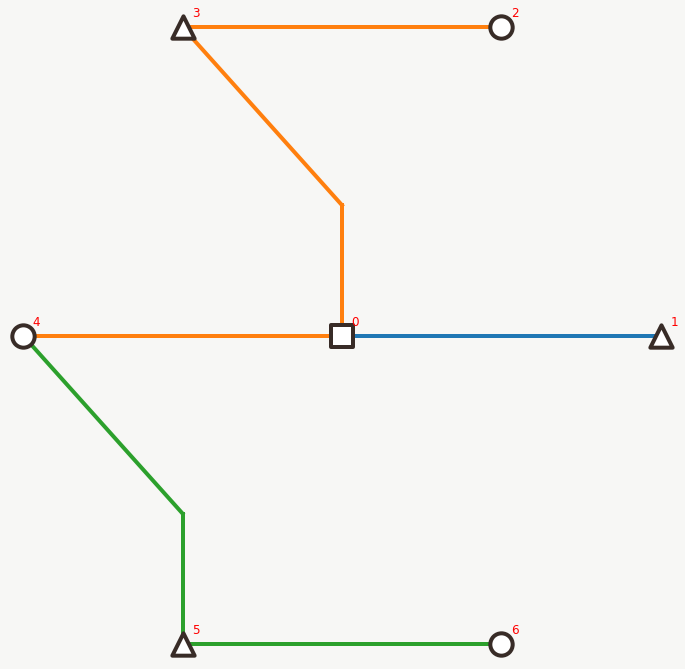

In [31]:
graph(stations, rails)

## Ant - Based Implementation (Callum WIP)

In [20]:
# Has inherited all hyperparameters from a cell above
m = gp.Model()
K = 1

# node i --> node j on path from depot k
x = m.addVars(N_STATIONS+1, N_STATIONS+1, M, vtype=GRB.INTEGER, name="x")
# node i potential, ONLY for actual customers (not dummy) MODIFIED
u = m.addVars(N_STATIONS, M, vtype=GRB.INTEGER, name="u")

# MODIFIED: k depots --> one depot, which is dummy. So D now represents routes, NOT sources.
m.setObjective(gp.quicksum(cost[i, j]*x[i, j, k] for k in D for j in V0 for i in V0), GRB.MINIMIZE)

# 2
m.addConstrs(gp.quicksum(x[DUMMY, j, k] for j in V) == mk for k in D)
# 3: MODIFIED - to allow cross-over
m.addConstrs(gp.quicksum(x[i, j, k] for k in D for i in V0) >= 1 for j in V)
# m.addConstrs(gp.quicksum(x[k, j, k] for k in D) + gp.quicksum(x[i, j, k] for k in D for i in V) == 1 for j in V)

# 4 SIMPLIFIED
m.addConstrs(gp.quicksum(x[i, j, k] for i in V0) - gp.quicksum(x[j, i, k] for i in V0) == 0 for k in D for j in V)
# 5 PRETTY SURE CAN BE MERGED INTO 4 BUT LEFT IT HERE
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) - gp.quicksum(x[j, k, k] for j in V) == 0 for k in D)


# 6: UPPER-BOUND L. POTENTIAL CONSTRICTIONS, ESP. ENFORCING L AS A LIMIT.
# L APPEARS TO 'INCLUDE' THE DEPOT
m.addConstrs(u[i,k] + (L - 2)*gp.quicksum(x[DUMMY, i, k] for k in D) - 
              gp.quicksum(x[i, DUMMY, k] for k in D) <= L - 1 for i in V for k in D)
# 7: LOWER-BOUND U. READS LIKE FORCING END-OF-LINE STATIONS TO MEET THE LOWER BOUND
# SEEMS LIKE IF K=3 THEN THERE ARE 3 TRAINSTOPS EXCLUDING THE DEPOT
m.addConstrs(u[i,k] + gp.quicksum(x[DUMMY, i, k] for k in D) + (2 - K)*gp.quicksum(x[i, DUMMY, k] for k in D) >= 2 \
             for i in V for k in D)
# 8: Can't just leave depot then come back.
m.addConstrs(gp.quicksum(x[DUMMY, i, k] for k in D) + gp.quicksum(x[i, DUMMY, k] for k in D) <= 1 for i in V)
# 9: SEC enforcement, L is a nice proxy here for max potential
m.addConstrs(u[i,k] - u[j,k] + L*gp.quicksum(x[i, j, k] for k in D) + \
              (L - 2)*gp.quicksum(x[j, i, k] for k in D) <= L - 1 + \
                  (N_STATIONS+1)*x[j,DUMMY,k] for i in V for j in V if i != j for k in D)


# 10 MODIFIED - include depot
m.addConstrs(x[i, i, k] == 0 for i in V0 for k in D)

# EXTRA constraints (particularly given the ghost depot)
# X2. For a given v, you must (and only once) enter the dummy depot, and leave the dummy depot
m.addConstrs(gp.quicksum(x[DUMMY,i,k] for i in V) == mk for k in D)
m.addConstrs(gp.quicksum(x[i,DUMMY,k] for i in V) == mk for k in D)
# X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
# X4. Routes must have more than 2 edges CHECKHCKECHCKEHCJ
m.addConstrs((gp.quicksum(x[i,j,k] for i in V0 for j in V0) >= 3 for k in D))

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 389 rows, 213 columns and 2520 nonzeros
Model fingerprint: 0xcde52aa5
Variable types: 0 continuous, 213 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 5.8806136
Presolve removed 114 rows and 30 columns
Presolve time: 0.01s
Presolved: 275 rows, 183 columns, 2130 nonzeros
Variable types: 0 continuous, 183 integer (162 binary)

Root relaxation: objective 4.000000e+00, 70 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       4.0000000    0.00000   100%     -    0s
     0     0          -    0         4

### (Mostly out-of-context thoughts) 

### Open problems and relevant discussion

Problems:

1. 'as-is' DFJ SEC in Archetti et al. didn't work, in part because you 'want' some of the kinds of subtour behaviour (customer-to-customer) that it is trying to stop.
    - PATH 1 (implemented): Use MTZ SEC's instead
    - PATH 2a: Allow the subtour if the subset exactly matches with a current vehicle route (quantified by `|S| == sum(x[i,j,v] for i in S for j in S) for any v in V`). Be careful to allow 'subtours' that connect to the depot, but not 'subtours' that ignore the depot.
    - PATH 2b: Use disjunctive ideas to deactivate the |S|-1 constraint in such a situation.
        - SOLN IDEA: the constr is `(E(S,v) <= |S| - 1 + 10e6*(E(S,v) == E(v))`
        - OR set `f[s,v]` integer and constrain with `f[s,v] <= E[v] - E[s,v]`


2. Loops, while permissible upon a solution to (P1) are not optimal, as it is always cheaper to just form a straight route and then go back to dummy-depot.
    - NOTE: It is easily verified that loops are now allowed by setting the cost matrix to be 100% negative, encouraging as long a path as it can have (which is `N_STATIONS+1`). Not very tractable for gurobi though


3. Actual optimisation for MM goals (high station diversity, all-types-reachable). I suspect the 'demand satisfaction' idea can effectively be chucked with zero consequences. Heuristic arguments can be used to motivate these issues.


4. My drafted algorithm is slow for 3-cluster (i.e. `N_STATIONS=12`) where the clusters were forced to connect; more constraints may hinder this. Regardless, some optimisations to the solution procedure, perhaps in the Tabu paper or hinted at in the survey, may be important for pushing forward.


5. Ignoring what I've done, there's an awful lot of 'many-paths-work' once you utilise dummy depots. Ant, nonfixed MmTSP, SDVRP, all can work. So it's a matter of choice.
- Caveat I've noticed: Ant can be well-enough adapted to allow loops IF you set up TWO dummy depots... otherwise you have to kill (8). It's been causing problems for me
> Apologies, but while I'm confident the SDVRP-based will not form bad subtours, I can't remember the reasoning

6. If costs satisfy triangle inequality, the SDVRP optimals have one overlapping customer, max. This would allow another constraint, that each edge can only be crossed by one train max (though that violates some play strategy in MM).
    - (but what if d >>>> Q?)
    - I conjecture it is true for MM since d(a,b) - |b-a| is upper-bounded at ~9% of ||b-a|| and any 3 points will have a corresponding 'convex' path

Random:

- Allowing boosted train capacity (since carriages possible)
- `hexagon` + biased demand weights == easy check that overlap is okay
- `loop_feasibility` + negative costs == easy check that loops are okay 
- `donut` == easy check for a problem that needs a loop solution

# Stage 2 - Brute-Force

In [ ]:
import networkx as nx

def cost(rails):
    # Find distance between all pairs of stations
    G=nx.Graph()

    elist = []
    for rail in rails:
        start = rail[0]
        for end in rail[1:]:
            elist.append((start, end, dist[start.id, end.id]))
            start = end    

    G.add_weighted_edges_from(elist)
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for start, paths in all_paths:

        distances = {kind: 1e12 for kind in all_kinds}

        # Get its kind
        for end, path in paths.items():
            # For each other station: If kind is different
            if start.kind != end.kind:
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(path))

        station_dists.append(sum(distances.values()))

    return sum(station_dists)

In [ ]:
from math import factorial
from itertools import permutations

def brute_force_tsp(stations):
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        perm = [perm]
        
        dist = cost(perm)
        if dist < max_dist:
            max_dist = dist
            best = perm
            
    return best

a = brute_force_tsp(stations)

In [ ]:
a

In [ ]:
graph(stations, a)

In [ ]:
from math import factorial

def brute_force_tsp(stations):
    ''' This doesn't allow for loops or overlapping sections but it should '''
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        for split in range(2, len(perm)):
            split = [perm[:split], perm[split:]] 

            dist = cost(split)
            if dist < max_dist:
                max_dist = dist
                best = split
            
    return best

a = brute_force_tsp(stations)

In [ ]:
a

In [ ]:
graph(stations, a)